In [126]:
%matplotlib inline

In [1]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import torch
from matplotlib.animation import FuncAnimation

In [5]:
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

In [3]:
from IPython import display

In [4]:
plt.ion()

In [6]:
is_ipython

True

In [6]:
import tqdm.auto as tqdm
import ipywidgets as widgets

In [7]:
env = gym.make(
    "LunarLander-v2",
    continuous= False,
    gravity= -10.0,
    enable_wind= False,
    wind_power= 15.0,
    turbulence_power= 0.8,
)

In [8]:
states = env.observation_space.shape[0]
actions = env.action_space.n

print(states, actions)

8 4


In [9]:
env.reset()

(array([ 0.00639915,  1.42014   ,  0.6481414 ,  0.40975836, -0.00740816,
        -0.14681387,  0.        ,  0.        ], dtype=float32),
 {})

In [10]:
episodes = 10

for episode in tqdm.trange(episodes):
    state = env.reset()
    terminated = False
    truncated = False
    score = 0

    while not terminated and not truncated:
        action = env.action_space.sample()
        state, reward, terminated, truncated, _ = env.step(action)
        score += reward
    print(f"Action: {action}, Reward: {reward}, Score: {score}")
    score = 0
    


  0%|          | 0/10 [00:00<?, ?it/s]

Action: 3, Reward: -100, Score: -170.3944372611528
Action: 1, Reward: -100, Score: -176.47195550352023
Action: 1, Reward: -100, Score: -106.95769733914034
Action: 1, Reward: -100, Score: -111.47046189472131
Action: 3, Reward: -100, Score: -81.6558915090173
Action: 3, Reward: -100, Score: -96.40617296322175
Action: 1, Reward: -100, Score: -61.056909738854195
Action: 3, Reward: -100, Score: -119.83415111381768
Action: 2, Reward: -100, Score: -389.63052893679725
Action: 0, Reward: -100, Score: -114.95837868295945


In [11]:
state = env.reset()[0]
state

array([-0.00463505,  1.4133776 , -0.46948513,  0.1092181 ,  0.00537755,
        0.10634538,  0.        ,  0.        ], dtype=float32)

In [12]:
action = env.action_space.sample()
action

1

In [13]:
state, reward, terminated, truncated, _ = env.step(action)
state

array([-0.00934181,  1.4152625 , -0.47780886,  0.08372675,  0.01242886,
        0.1410398 ,  0.        ,  0.        ], dtype=float32)

In [14]:
Q_table = np.zeros((states, actions))

Q_table

array([[0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.]])

In [15]:
x_position = np.linspace(-1, 1, 10)
y_position = np.linspace(-1, 1, 10)
x_velocity = np.linspace(-1, 1, 10)
y_velocity = np.linspace(-1, 1, 10)
angle = np.linspace(-1, 1, 10)
angular_velocity = np.linspace(-1, 1, 10)
left_leg = np.linspace(0, 1, 2)
right_leg = np.linspace(0, 1, 2)

In [16]:
left_leg

array([0., 1.])

In [17]:
Q_table = np.zeros((len(x_position)+1, len(y_position)+1, len(x_velocity)+1, len(y_velocity)+1, len(angle)+1, len(angular_velocity)+1, len(left_leg)+1, len(right_leg)+1, actions))
Q_table.shape

(11, 11, 11, 11, 11, 11, 3, 3, 4)

In [18]:
plt.ion()

In [19]:
episode_durations = []

In [20]:
def plot_durations(show_result=False):
    plt.figure(1)
    durations_t = torch.tensor(episode_durations, dtype=torch.float)
    if show_result:
        plt.title('Result')
    else:
        plt.clf()
        plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(durations_t.numpy())
    # Take 100 episode averages and plot them too
    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())

    plt.pause(0.001)  # pause a bit so that plots are updated
    if is_ipython:
        if not show_result:
            display.display(plt.gcf())
            display.clear_output(wait=True)
        else:
            display.display(plt.gcf())


In [21]:
episode_rewards = []

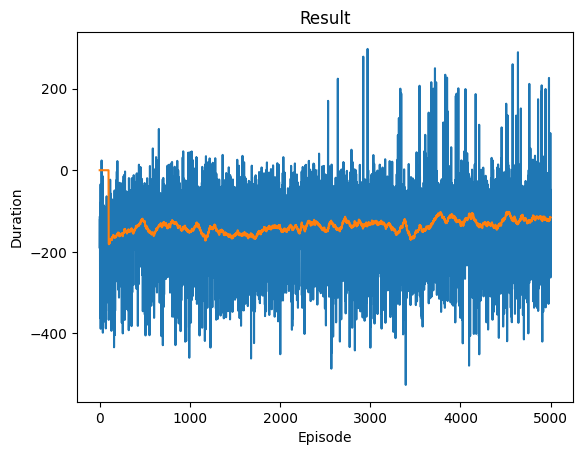

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [22]:
# Hyperparameters
alpha = 0.1
gamma = 0.9
epsilon = 1.0
epsilon_decay = 0.001
episodes = 5000

# Training
for episode in tqdm.trange(episodes):
    state = env.reset()[0]
    terminated = False
    truncated = False
    score = 0

    state_x_position = np.digitize(state[0], x_position)
    state_y_position = np.digitize(state[1], y_position)
    state_x_velocity = np.digitize(state[2], x_velocity)
    state_y_velocity = np.digitize(state[3], y_velocity)
    state_angle = np.digitize(state[4], angle)
    state_angular_velocity = np.digitize(state[5], angular_velocity)
    state_left_leg = np.digitize(state[6], left_leg)
    state_right_leg = np.digitize(state[7], right_leg)

    while not terminated and not truncated:
        if np.random.random() < epsilon:
            action = env.action_space.sample()
        else:
            action = np.argmax(Q_table[state_x_position, state_y_position, state_x_velocity, state_y_velocity, state_angle, state_angular_velocity, state_left_leg, state_right_leg, :])

        next_state, reward, terminated, truncated, _ = env.step(action)

        next_state_x_position = np.digitize(next_state[0], x_position)
        next_state_y_position = np.digitize(next_state[1], y_position)
        next_state_x_velocity = np.digitize(next_state[2], x_velocity)
        next_state_y_velocity = np.digitize(next_state[3], y_velocity)
        next_state_angle = np.digitize(next_state[4], angle)
        next_state_angular_velocity = np.digitize(next_state[5], angular_velocity)
        next_state_left_leg = np.digitize(next_state[6], left_leg)
        next_state_right_leg = np.digitize(next_state[7], right_leg)

        Q_table[state_x_position, state_y_position, state_x_velocity, state_y_velocity, state_angle, state_angular_velocity, state_left_leg, state_right_leg, action] = Q_table[state_x_position, state_y_position, state_x_velocity, state_y_velocity, state_angle, state_angular_velocity, state_left_leg, state_right_leg, action] + alpha * (reward + gamma * np.max(Q_table[next_state_x_position, next_state_y_position, next_state_x_velocity, next_state_y_velocity, next_state_angle, next_state_angular_velocity, next_state_left_leg, next_state_right_leg, :]) - Q_table[state_x_position, state_y_position, state_x_velocity, state_y_velocity, state_angle, state_angular_velocity, state_left_leg, state_right_leg, action])

        state_x_position = next_state_x_position
        state_y_position = next_state_y_position
        state_x_velocity = next_state_x_velocity
        state_y_velocity = next_state_y_velocity
        state_angle = next_state_angle
        state_angular_velocity = next_state_angular_velocity
        state_left_leg = next_state_left_leg
        state_right_leg = next_state_right_leg

        score += reward    

        if terminated or truncated:
            episode_durations.append(score)
            plot_durations()
            epsilon = max(0.1, epsilon - epsilon_decay)
            break

plot_durations(show_result=True)
plt.ioff()
plt.show()

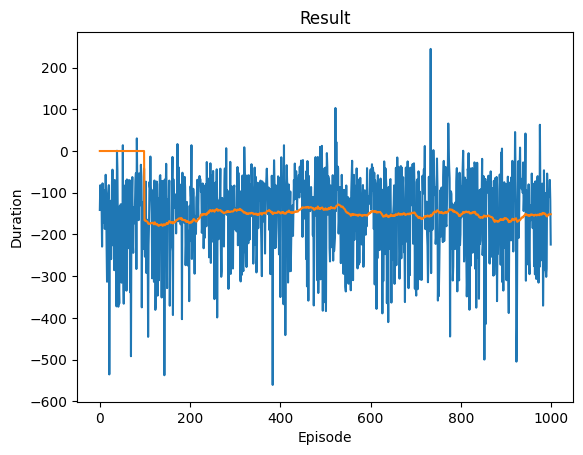

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [58]:
plot_durations(show_result=True)
plt.ioff()
plt.show()

In [59]:
env.close()